In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import itertools

In [2]:
DIRECTORY = './data/'
categories = pd.read_csv(DIRECTORY + 'item_categories.csv')
items = pd.read_csv(DIRECTORY + 'items.csv')
shops = pd.read_csv(DIRECTORY + 'shops.csv')
train = pd.read_csv(DIRECTORY + 'sales_train.csv', parse_dates=['date'], date_format='%d.%m.%Y')
test = pd.read_csv(DIRECTORY + 'test.csv')

# Goal & Direction

- Investigate MSE source (from guessing last month)
- Look at November 2014 specifically (can also do 2013)
- Look specifically at Section 1
    - items are old (have existed in train)
    - item-shop combo has been seen before in train at least once

- Thoughts
    - group by category
    - are our predictions too high or too low

- hw: investigate why the MSE is 2 in type 1 (same store/item combos are there in train)
    - what are the items contributing to HIGH MSE (like getting 20s when last month it was 1)

In [3]:
train['month'] = train['date'].dt.to_period('M')
chosen_month = pd.to_datetime('11-2014').to_period('M')

sub_train = train[train['month'] < chosen_month]
sub_test = train[train['month'] == chosen_month]

In [ ]:
all_rows = pd.DataFrame(data=itertools.product(sub_test['shop_id'].unique(), sub_test['item_id'].unique()), columns=['shop_id', 'item_id'])
type1_rows = all_rows.merge(sub_train[['shop_id', 'item_id']].drop_duplicates(), on=['shop_id', 'item_id'], how='inner')

last_month_train = train[train['month'] == (chosen_month - 1)]
train_aggregated = last_month_train.groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('prediction').reset_index()
test_aggregated = sub_test.groupby(by=['shop_id', 'item_id'])['item_cnt_day'].sum().to_frame('answers').reset_index()


predictions = type1_rows.merge(train_aggregated, on=['shop_id', 'item_id'], how='left')
predictions = predictions.merge(test_aggregated, on=['shop_id', 'item_id'], how='left')
predictions = predictions.fillna(0)

,shop_id,item_id,prediction,answers
0,37,4615,0.0,0.0
1,37,4870,1.0,2.0
2,37,4872,2.0,5.0
3,37,4873,2.0,1.0
4,37,4886,0.0,0.0
...,...,...,...,...
158018,42,13548,4.0,2.0
158019,42,20554,0.0,0.0
158020,42,14112,0.0,1.0
158021,42,14224,0.0,1.0


In [53]:
# # investigate mses
predictions['answers'] = np.clip(predictions['answers'], 0, 20)
predictions['prediction'] = np.clip(predictions['prediction'], 0, 20)
predictions['mse'] = (predictions['answers'] - predictions['prediction'])**2
predictions['mse'].mean()

1.5295305113812547

In [54]:
bins = [-1,0,1,4,9,25,100,500]
predictions['mse_bins'] = pd.cut(predictions['mse'], bins=bins)
predictions['mse_bins'].value_counts()

mse_bins
(-1, 0]       109241
(0, 1]         36186
(1, 4]          7352
(4, 9]          2382
(9, 25]         1620
(25, 100]        894
(100, 500]       348
Name: count, dtype: int64

In [55]:
# how much are these bins contributing to total rmse
predictions.groupby(by='mse_bins', observed=False)['mse'].agg(['mean', 'sum', 'count'])

,mean,sum,count
mse_bins,,,
"(-1, 0]",0.000000,0.0,109241
"(0, 1]",1.000000,36186.0,36186
"(1, 4]",4.000000,29408.0,7352
"(4, 9]",9.000000,21438.0,2382
"(9, 25]",19.011111,30798.0,1620
"(25, 100]",55.077181,49239.0,894
"(100, 500]",214.459770,74632.0,348


In [101]:
intervals = np.sort(predictions['mse_bins'].unique())
highest_bin = predictions[predictions['mse_bins'] == intervals[-1]]

display(highest_bin['shop_id'].unique()) # all the shows are included
display(highest_bin['item_id'].unique()) # multiple relevant items
print(f'prediction mean: {highest_bin['prediction'].mean():.2f}', f'answer mean: {highest_bin['answers'].mean():.2f}')

high_error_items = highest_bin['item_id'].unique()


array([37, 31, 35, 58, 59, 29, 30, 28, 54, 53, 50, 51, 49, 48, 52, 57, 56,
       55, 15, 16, 12, 14, 18, 19, 17,  5,  6,  2,  3,  7, 10, 27, 26, 25,
       21, 24, 22, 44, 45, 41, 46, 38, 40, 39, 43, 47, 42])

array([17717, 19436, 19439,  7864,  3237,  3552, 16287, 15268,  6763,
        7815,  7780, 10512, 10480, 21386, 21762,  2780,  2814,  1384,
        1387,  2039,  1389,  9396, 14128,  7852, 10435, 10514, 10513,
       16566, 14127,  1440,  3054,  3340,  4493, 12362,  4181,  3341,
       14126, 10511, 22088,  5827, 14842,  4244,  2308,  7856,  9355,
        1099,  1824,  6436,  3234, 17269, 14831, 10479, 14305,  3343,
        6503,  3342,  9462,   472,  3038,  3465,  3418,  3454,  1828,
        1551,  2038, 19446, 19437,  6939,  6937,  4492,  6504,   806,
       15994, 17654,  5837, 11365,  5823, 20949,  3346, 14830,  4873,
        5821,  3553, 16787,  6888,  7159, 21420, 17167, 16565, 11173,
       12610,  8293,  9240,  4872,  6502, 20608, 19051,  8226])

prediction mean: 15.11 answer mean: 5.18


Finding: we are guessing way too high (items are dying)

(array([516, 528, 540]),
 [Text(516, 0, 'Jan\n2013'),
  Text(528, 0, 'Jan\n2014'),
  Text(540, 0, 'Jan\n2015')])

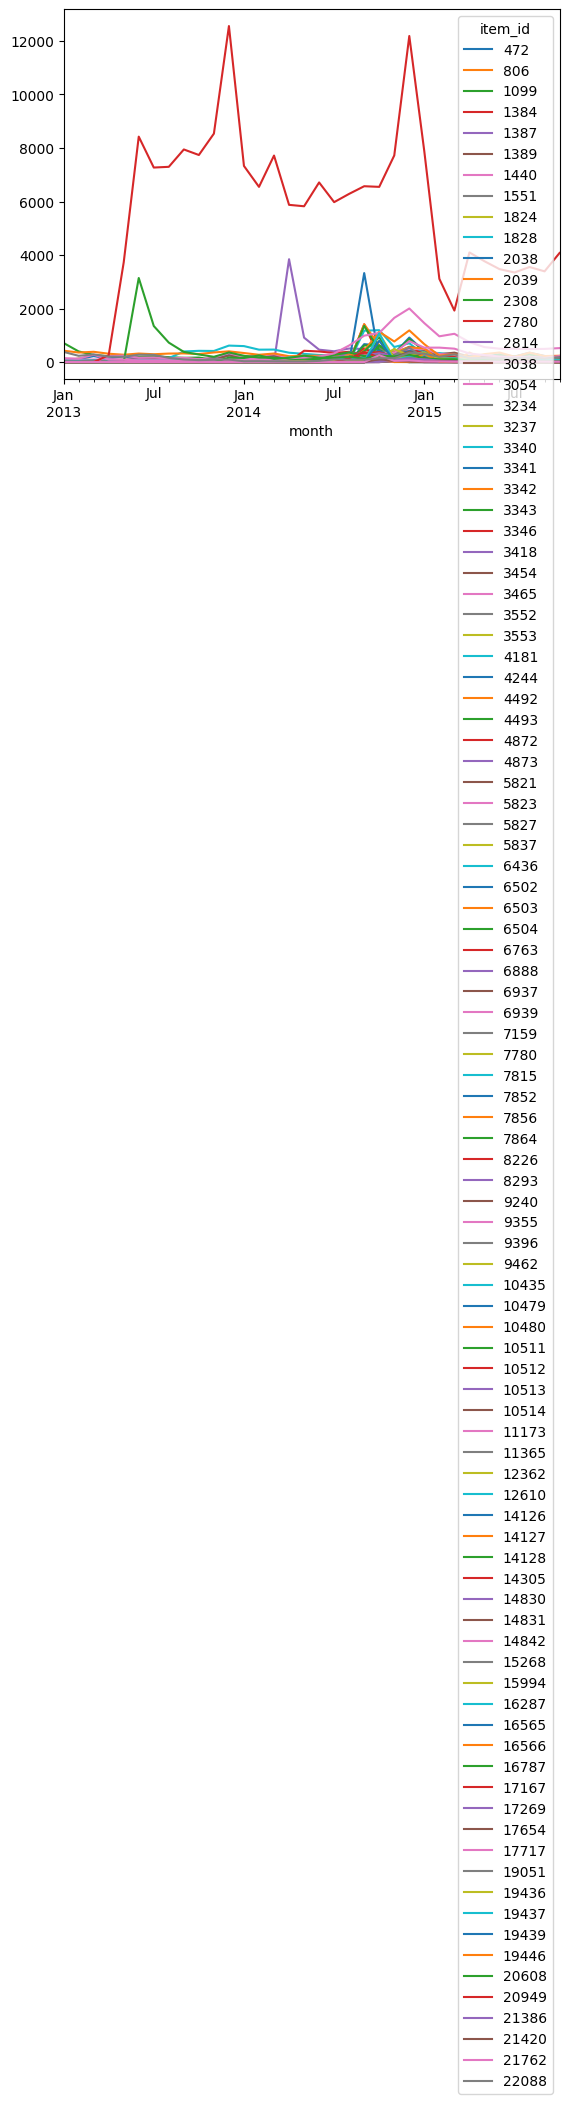

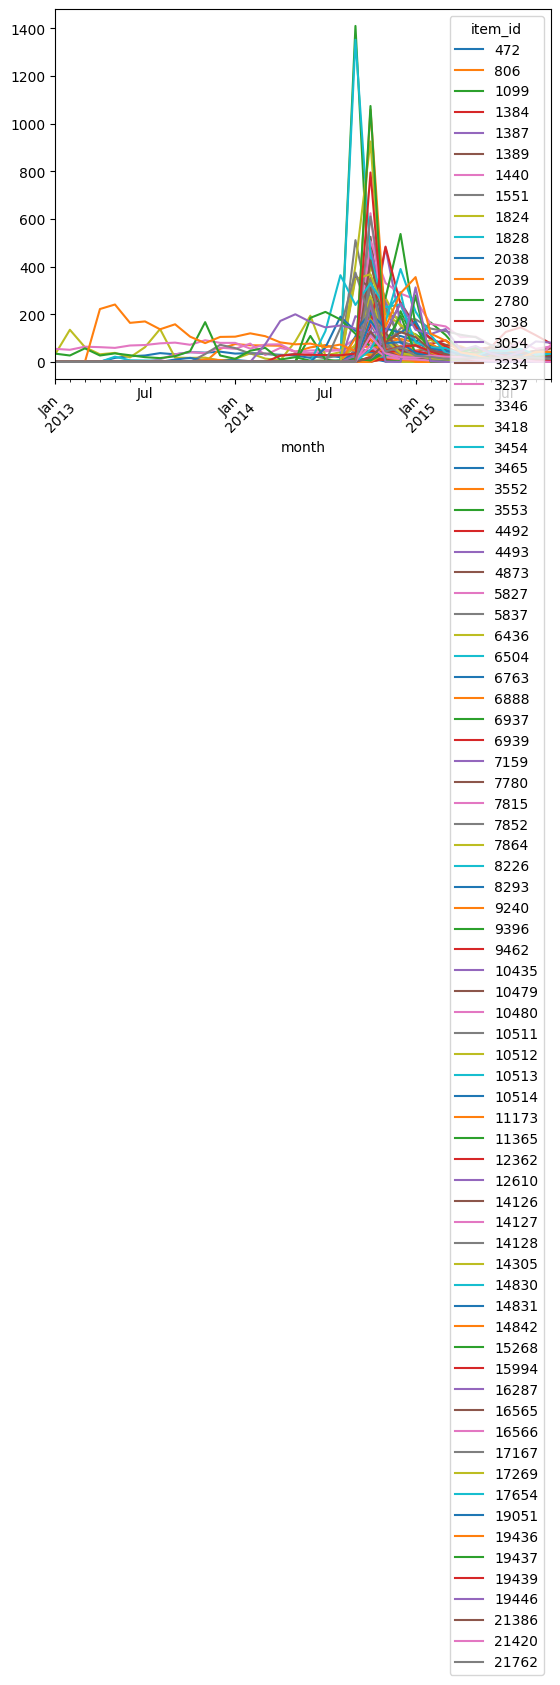

In [137]:
# graph item sales for these items

monthly_hei_sales = train[train['item_id'].isin(high_error_items)]\
    .groupby(by=['month', 'item_id'])['item_cnt_day'].sum().unstack().fillna(0)

monthly_hei_sales.plot()

filtered_monthly_sales = monthly_hei_sales.drop(columns=monthly_hei_sales.sum().nlargest(20).index)
filtered_monthly_sales.plot()
plt.xticks(rotation=45)

# High error items: 98
# Items that were not there two months ago: 39


<Axes: xlabel='month'>

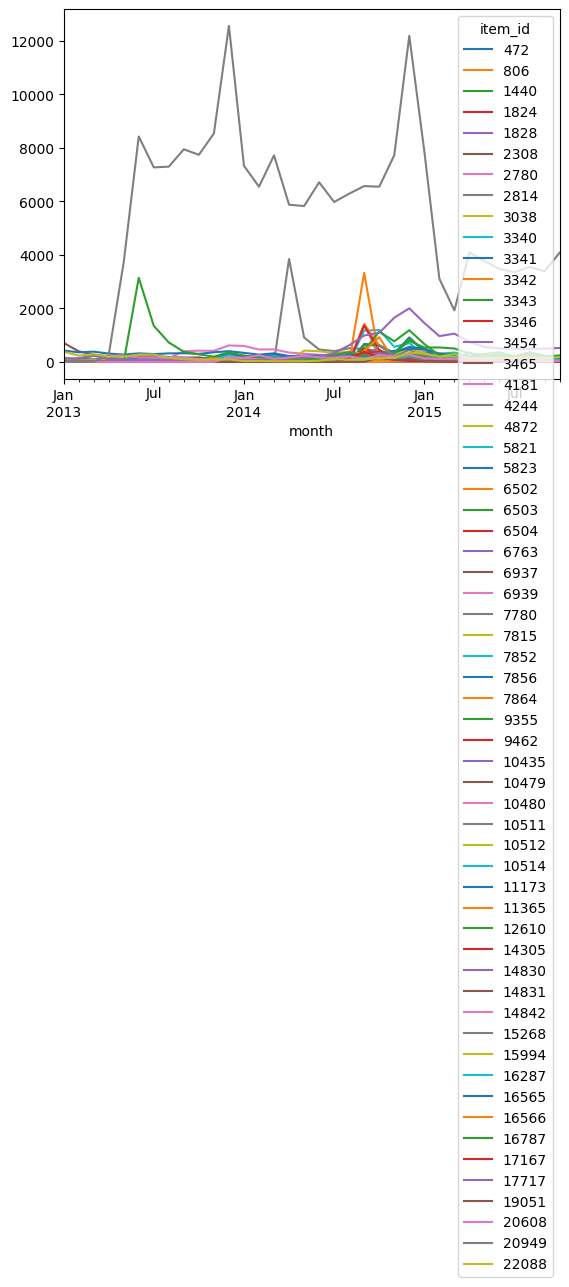

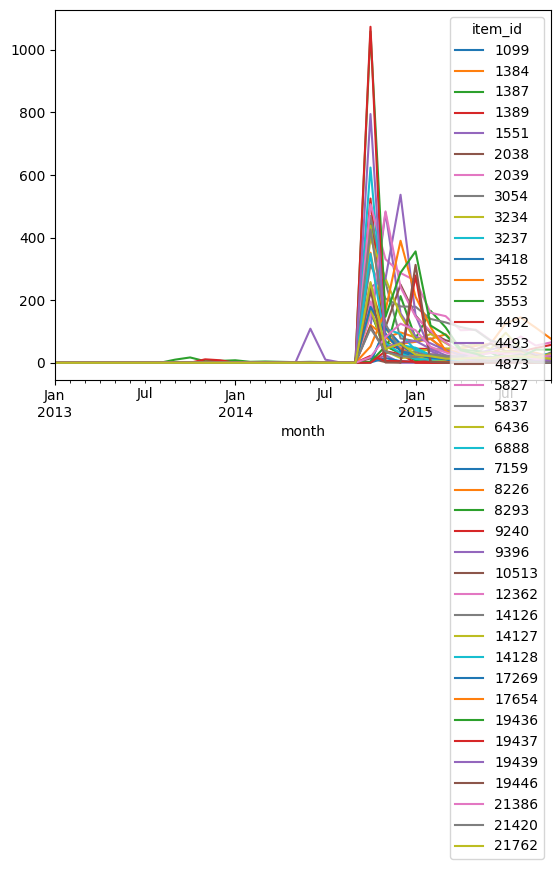

In [135]:
# check how many were 0 in october
print("# High error items:", len(high_error_items))
two_months_ago = train[train['item_id'].isin(high_error_items) & (train['month'] == (chosen_month - 2))]

not_there_two_months_ago = np.setdiff1d(high_error_items, two_months_ago['item_id'])
print("# Items that were not there two months ago:", len(not_there_two_months_ago))

monthly_hei_sales.drop(columns=not_there_two_months_ago).plot() # were there two months ago
monthly_hei_sales[not_there_two_months_ago].plot()

In [108]:
# see what the ratio tends to be
highest_bin = highest_bin.copy()
highest_bin['ratio'] = ((highest_bin['prediction'] + np.finfo(float).eps)/(highest_bin['answers'] + np.finfo(float).eps))

bins=[0,0.2, 0.4, 0.5, 1, 1.5, 2, 3, 5,10,np.inf]
highest_bin['ratio_bins'] = pd.cut(highest_bin['ratio'], bins=bins)
highest_bin['ratio_bins'].value_counts().sort_index()

# validate that all same

ratio_bins
(0.0, 0.2]      30
(0.2, 0.4]      23
(0.4, 0.5]       2
(0.5, 1.0]       0
(1.0, 1.5]       0
(1.5, 2.0]       0
(2.0, 3.0]      44
(3.0, 5.0]      62
(5.0, 10.0]     66
(10.0, inf]    121
Name: count, dtype: int64

In [110]:
# see what the dif. tends to be
highest_bin['diff'] = highest_bin['prediction'] - highest_bin['answers']

bins=[-30, -21, -15, -10, 0, 9, 10, 15, 20, 30]
highest_bin['diff_bins'] = pd.cut(highest_bin['diff'], bins=bins)
highest_bin['diff_bins'].value_counts().sort_index()
# validate that all same

diff_bins
(-30, -21]      0
(-21, -15]     20
(-15, -10]     35
(-10, 0]        0
(0, 9]          0
(9, 10]         0
(10, 15]      192
(15, 20]      101
(20, 30]        0
Name: count, dtype: int64

In [136]:
monthly_hei_sales

item_id,472,806,1099,1384,1387,1389,1440,1551,1824,1828,...,19436,19437,19439,19446,20608,20949,21386,21420,21762,22088
month,,,,,,,,,,,,,,,,,,,,,
2013-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,380.0
2013-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,233.0
2013-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,286.0
2013-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,...,0.0,0.0,0.0,0.0,0.0,255.0,0.0,0.0,0.0,203.0
2013-05,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,38.0,22.0,...,0.0,0.0,0.0,0.0,0.0,3727.0,0.0,0.0,0.0,196.0
2013-06,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,7.0,...,0.0,0.0,0.0,0.0,0.0,8424.0,0.0,0.0,0.0,275.0
2013-07,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,62.0,6.0,...,0.0,0.0,0.0,0.0,0.0,7269.0,0.0,0.0,0.0,270.0
2013-08,37.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,138.0,5.0,...,0.0,0.0,0.0,0.0,0.0,7296.0,0.0,0.0,0.0,156.0
2013-09,32.0,0.0,0.0,0.0,0.0,0.0,32.0,0.0,18.0,1.0,...,0.0,0.0,0.0,0.0,0.0,7945.0,0.0,0.0,0.0,97.0


# What types of items is it

In [149]:
high_error_item_df = pd.DataFrame(data={'item_id': high_error_items})
high_error_item_df = high_error_item_df.merge(items, on=['item_id'], how='left')
display(high_error_item_df['item_category_id'].value_counts().head(10))

high_error_item_df['item_first_word'] = high_error_item_df['item_name'].str.replace('\"', '').str.split().str[0]
display(high_error_item_df['item_first_word'].value_counts().head(10))

high_error_item_df = high_error_item_df.merge(categories, on=['item_category_id'], how='left')
high_error_item_df['category_first_word'] = high_error_item_df['item_category_name'].str.replace('\"', '').str.split().str[0]
display(high_error_item_df['category_first_word'].value_counts().head(10))

item_category_id
40    13
30    13
31    12
20     8
55     5
65     5
28     5
37     5
49     4
19     3
Name: count, dtype: int64

item_first_word
FIFA           5
Средиземье:    4
ГРАНЬ          4
Alien:         3
World          3
Sims           3
МТГ(РУС):      3
ЛЮДИ           3
Lords          2
Pokemon        2
Name: count, dtype: int64

category_first_word
Игры         46
Кино         22
Подарки      12
Музыка        5
Книги         4
Программы     3
Карты         3
Служебные     1
Элементы      1
Доставка      1
Name: count, dtype: int64